## Overview

1. Feature Engineering
2. Stacking
3. Feature importance
4. XGBoost Stacking

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold;

# 1. Feature Exploration, Engineering and Cleaning

In [2]:
train = pd.read_csv('data/train_ensemble.csv')
test = pd.read_csv('data/test_ensemble.csv')

### Store passenger ID for easy access


PassengerId = test['PassengerId']

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
full_data = [train,test]

# Some features of my own that I have added in
# Gives the length of the name

train["Name_length"] = train['Name'].apply(len)
test['Name_length'] = train['Name'].apply(len)

## Feature that tells whether a passenger had a cabin on boat
### nan type = float,but string (if has cabin) return false

train["Has_Cabin"] = train["Cabin"].apply(lambda x:0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x:0 if type(x) == float else 1)


## Feature engineering
### Create new feature FamilySize

for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"]+dataset["Parch"]+1
    
## Create new feature IsAlone from FamilySize

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all nulls in Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset["Embarked"].fillna('S')
    

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train['Fare'].median())
    
### cut into 4 quantile group   
train['CategoricalFare'] = pd.qcut(train['Fare'],4)


## Create new feature CategoricalAge

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
 
# Used to cut into pieces
train['CategoricalAge'] = pd.cut(train['Age'],5)


### Define function to extract titles from passenger names 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.',name)
    
    ## If title exists, extract and return it
    if title_search:
        return title_search.group(1)
    
    return ""


## Create a new feature Title, containing the titles of passenger names

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col'
                                                 ,'Don', 'Dr', 'Major', 'Rev', 'Sir'
                                                 , 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    
for dataset in full_data:
    
    ## Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    
    ## Mapping titles
    title_mapping =  {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    
    ## Mapping embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    ## Mapping Fare
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91) & (dataset['Fare']<=14.454),'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454) & (dataset['Fare']<=31),'Fare'] =2
    dataset.loc[(dataset['Fare']>31,'Fare')] = 3
    
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    ## Mapping Age
    dataset.loc[dataset['Age']<=16,'Age'] = 0
    dataset.loc[(dataset['Age']>16) & (dataset['Age']<=32),"Age"] = 1
    dataset.loc[(dataset['Age']>32) & (dataset['Age']<=48),"Age"] = 2
    dataset.loc[(dataset['Age']>48) & (dataset['Age']<=64),"Age"] = 3
    dataset.loc[dataset['Age']>64,'Age'] = 4;
    
    

    

    
    

In [4]:
## Remove columns not used for prediction

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements,axis = 1)
train = train.drop(['CategoricalAge','CategoricalFare'],axis = 1)
test = test.drop(drop_elements,axis = 1)
train.head()


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


In [5]:
train.describe()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,1.359147,0.381594,1.505051,0.361392,26.965208,0.228956,1.904602,0.602694,1.728395
std,0.486592,0.836071,0.477990,0.843397,0.806057,1.118148,0.635673,9.281607,0.420397,1.613459,0.489615,1.030039
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,1.000000,0.000000,0.500000,0.000000,20.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,1.000000,0.000000,2.000000,0.000000,25.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,2.000000,0.000000,2.000000,1.000000,30.000000,0.000000,2.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,4.000000,6.000000,3.000000,2.000000,82.000000,1.000000,11.000000,1.000000,5.000000


## Visualization

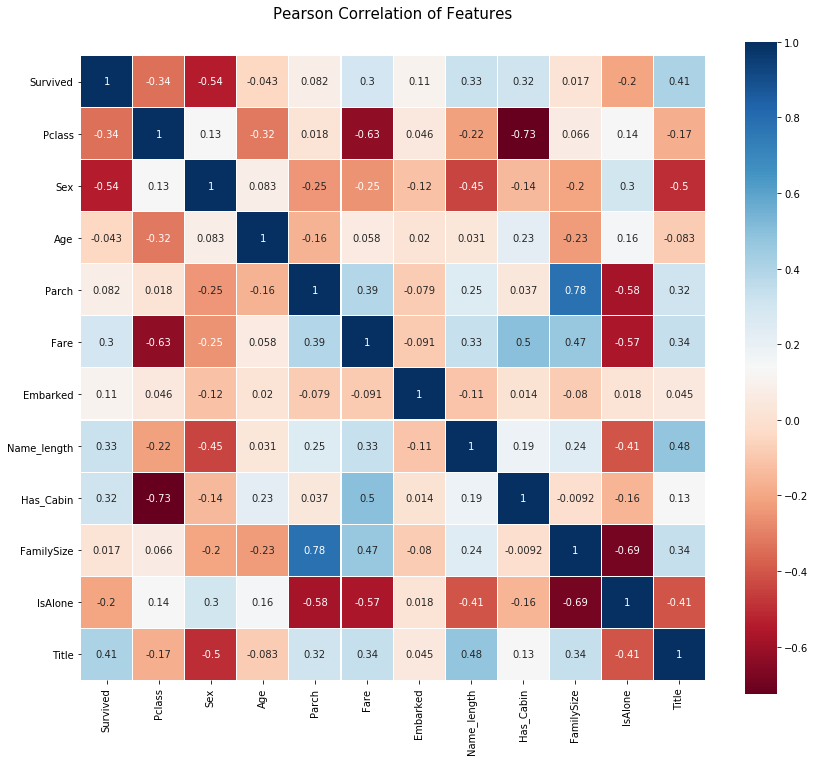

In [6]:
## Pearson correlation heat map
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## Create training data

In [7]:
x_train = train.drop(['Survived'],axis =1).values
y_train = train['Survived'].values
x_test = test.values
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc.fit(x_train)

x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

## Define Training Model

In [24]:
rf = RandomForestClassifier(n_estimators = 500,warm_start = True,max_depth = 6
                             ,min_samples_leaf = 2, max_features  ='sqrt',
                            verbose = 0,n_jobs= -1)


et = ExtraTreesClassifier(n_estimators = 500,max_depth = 8,min_samples_leaf = 2,
                         verbose = 0,n_jobs = -1)

ada =  AdaBoostClassifier(n_estimators = 500,learning_rate = 0.75)

gb = GradientBoostingClassifier(n_estimators = 500,max_depth = 5,min_samples_leaf = 1,
                               verbose = 0)

svc = SVC(kernel = 'linear',C = 0.025)



## Feature Importances

- SVM don't have feature importances

In [25]:
rf_features = rf.fit(x_train_std,y_train).feature_importances_
et_features = et.fit(x_train_std,y_train).feature_importances_
ada_features = ada.fit(x_train_std,y_train).feature_importances_
gb_features= gb.fit(x_train_std,y_train).feature_importances_

cols = train.drop(['Survived'],axis = 1).columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

feature_dataframe['mean'] = feature_dataframe.mean(axis = 1)
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.116811,0.123836,0.028,0.085804,0.088613
1,Sex,0.253453,0.385436,0.010,0.012928,0.165454
2,Age,0.032523,0.027088,0.018,0.050950,0.032140
3,Parch,0.020042,0.015683,0.066,0.013175,0.028725
4,Fare,0.047012,0.056018,0.040,0.058201,0.050308
5,Embarked,0.022710,0.028510,0.010,0.025666,0.021722
6,Name_length,0.108744,0.046048,0.692,0.175683,0.255619
7,Has_Cabin,0.065458,0.087730,0.014,0.038624,0.051453
8,FamilySize,0.070063,0.042966,0.046,0.109348,0.067094
9,IsAlone,0.011151,0.019797,0.004,0.006177,0.010281


### Base Model Prediction Accuracy

In [26]:

print('Random Forest Accuracy:',accuracy_score(y_true = y_train,y_pred = rf.predict(x_train_std)))
print('Extra Tree Accuracy:',accuracy_score(y_true = y_train,y_pred = et.predict(x_train_std)))
print('Adaboost Accuracy:',accuracy_score(y_true = y_train,y_pred = ada.predict(x_train_std)))
print('Gradient Boosting Accuracy:',accuracy_score(y_true = y_train,y_pred = gb.predict(x_train_std)))

Random Forest Accuracy: 0.8552188552188552
Extra Tree Accuracy: 0.8720538720538721
Adaboost Accuracy: 0.8462401795735129
Gradient Boosting Accuracy: 0.9685746352413019


### Meta classifier

In [27]:
gbm = xgb.XGBClassifier(
n_estimators = 5000,
max_depth = 6,
min_child_weight = 2,
gamma = 0.1,
subsample = 0.8,
colsample_bytree = 0.8,
objective = 'binary:logistic',
nthread = -1,
scale_pos_weight = 1).fit(x_train_std,y_train)



print('Extreme Gradient Boosting Accuracy:',accuracy_score(y_true = y_train,y_pred = gbm.predict(x_train_std)))


Extreme Gradient Boosting Accuracy: 0.9629629629629629


### Stacking

In [31]:
from mlxtend.classifier import StackingClassifier
sclf = StackingClassifier(classifiers = [rf,et,ada,gb,svc], meta_classifier = gbm)

sclf.fit(x_train_std,y_train)


print('Stacking Accuracy:',accuracy_score(y_true = y_train,y_pred = sclf.predict(x_train_std)))



Stacking Accuracy: 0.9685746352413019
